In [1]:
import sys
sys.path.append('../../shared')
from inject_tools import *

from pathlib import Path
from os.path import isfile, join
from tqdm import tqdm
from scipy import signal as scisig

import h5py
from os import listdir
from os.path import isfile, join
import numpy as np
import pandas as pd
from pathlib import Path
# import joblib

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
fw = 4*4096
Tc = 64
gps = event_gps('GW150914') - 100
segment = ((gps) - Tc / 2, (gps) + Tc / 2)
hdata = TimeSeries.fetch_open_data('H1', *segment, sample_rate=fw, verbose=True, cache=True)
times = hdata.times.value

Fetched 1 URLs from www.gw-openscience.org for [1126259330 .. 1126259395))
Reading data... [Done]


/anaconda2/envs/gw_env/lib/python3.7/site-packages/gwpy/types/series.py:926: UserWarning: TimeSeries.crop given end larger than current end, crop will end when the Series actually ends.
  % type(self).__name__)


In [149]:
ccsn_paper = 'abdikamalov'
data_path = Path('/Users/tommarianer/LOSC Data/ccsn/' + ccsn_paper)
files = [f for f in sorted(listdir(data_path)) if isfile(join(data_path, f))]

In [155]:
file = files[1]
data = [i.strip().split() for i in open(join(data_path, file)).readlines()]

In [156]:
fname = 'injected-' + ccsn_paper + '-' + '.'.join(file.split('.')[2:] + ['hdf5'])
print(file)
print(fname)

a_t.dat.A1O01.5
injected-abdikamalov-A1O01.5.hdf5


In [157]:
D_kpc = 10
D = D_kpc * 3.086e+21 # cm

sim_times = np.asarray([float(dat[0]) for dat in data])
hp = np.asarray([float(dat[1]) for dat in data]) / D

In [158]:
dt = sim_times[1] - sim_times[0]
hp = TimeSeries(hp, t0=sim_times[0], dt=dt)

hp = hp.resample(rate=fw, ftype = 'iir', n=20) # downsample to working frequency fw
hp = hp.highpass(frequency=11, filtfilt=True) # filter out frequencies below 20Hz
window = scisig.tukey(M=len(hp), alpha=0.08, sym=True)
hp = hp * window
hp = hp.pad(int((fw * Tc - len(hp)) / 2))

h_rss = np.sqrt(hp.dot(hp) * hp.dt).value
print(h_rss, h_rss / 1e-22)

2.1818751240573473e-22 2.1818751240573473


In [159]:
t_inj = gps - 0.7
shift = int((t_inj - (times[0] + Tc/2)) * fw)
print(shift)

hp = np.roll(hp.value, shift)

hp = TimeSeries(hp, t0=times[0], dt=hdata.dt)
try:
    hp = hp.taper()
except:
    print('Warning: no taper')

-11468


2.1818751240573473e-22 2.1818751240573473


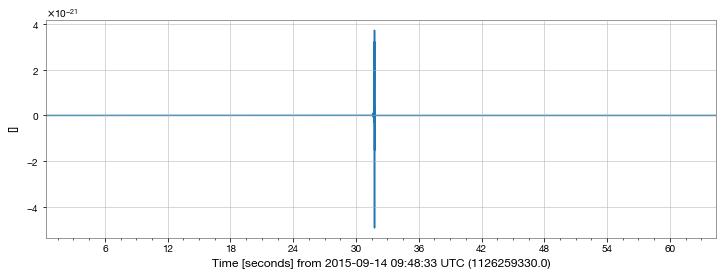

In [160]:
h_rss = np.sqrt(hp.dot(hp) * hp.dt).value

print(h_rss, h_rss / 1e-22)
hp.plot()
plt.show()

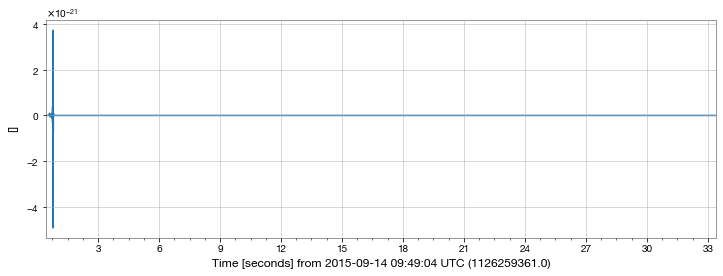

In [161]:
t_snr = 0.25
plot = hp.crop(t_inj - t_snr, gps + t_inj).plot()
plt.show()

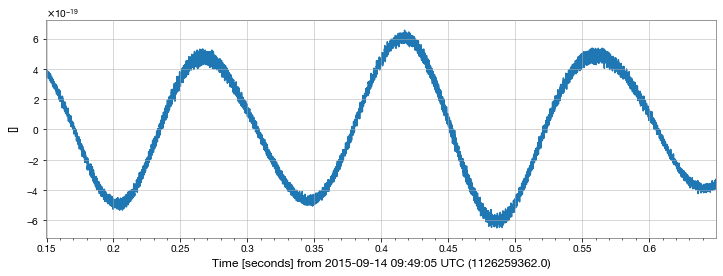

In [130]:
waveform_data = hdata.inject(hp)
plot = waveform_data.crop(gps - t_snr, gps + t_snr).plot()
plt.show()

In [131]:
qt = waveform_data.q_transform(frange=(10, 2048), qrange=(4, 64), whiten=True, tres=0.002)

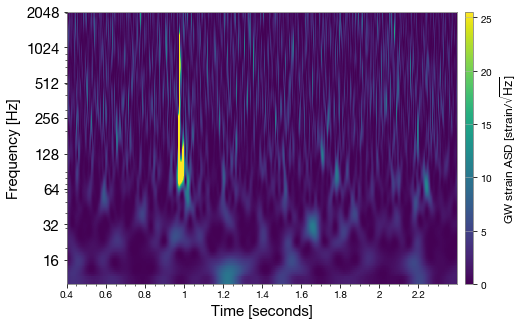

In [132]:
size = (7, 5)
plot = qt.crop(gps - 1, gps + 1).plot(figsize=size, vmin=0, vmax=25.5)
ax = plot.gca()
ax.set_ylim(10, 2048)
ax.set_yscale('log')
ax.colorbar(label='GW strain ASD [strain/$\sqrt{\mathrm{Hz}}$]')
ax.grid(False)
plt.xlabel('Time [seconds]', size=15)
plt.ylabel('Frequency [Hz]', size=15)
ytick_list = [16, 32, 64, 128, 256, 512, 1024, 2048]
ax.set_yticks(ytick_list)
ax.set_yticklabels([str(tick) for tick in ytick_list], size=15)
plot.show()

In [91]:
# data_path = Path('/Users/tommarianer/LOSC Data/ccsn')
# f = h5py.File(join(data_path, 'GWdatabase.h5'), 'r')
# print(f.keys())

In [92]:
# wf = list(f['waveforms'].keys())
# print(np.asarray(f['waveforms'][wf[0]]))
# h = np.asarray(f['waveforms'][wf[0]]['strain*dist(cm)'])
# times = np.asarray(f['waveforms'][wf[0]]['t-tb(s)'])

In [93]:
# print(h.shape)
# plt.plot(times, h)
# plt.show()